In [147]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
import optuna
import wandb
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import accuracy_score, f1_score, recall_score

# Downloading file from Wandb 

In [148]:
run = wandb.init(project="risk_credit", job_type="EDA")

In [149]:
WANDB_API_KEY=os.environ.get('1d620fa1eff54f2f0ba01b14c81969f4ce70bd6c')
!wandb login --relogin 1d620fa1eff54f2f0ba01b14c81969f4ce70bd6c

wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\PC\_netrc
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


In [150]:
artifact_X_train = wandb.use_artifact('risk_credit/X_train.csv:latest', type='Preprocessing')
artifact_X_test = wandb.use_artifact('risk_credit/X_test.csv:latest', type='Preprocessing')
artifact_y_train = wandb.use_artifact('risk_credit/y_train.csv:latest', type='Preprocessing')
artifact_y_test = wandb.use_artifact('risk_credit/y_test.csv:latest', type='Preprocessing')

X_train_dir = artifact_X_train.download()
X_test_dir = artifact_X_test.download()
y_train_dir = artifact_y_train.download()
y_test_dir = artifact_y_test.download()

wandb.finish()

X_train_path = os.path.join(X_train_dir, "X_train.csv")
X_test_path = os.path.join(X_test_dir, "X_test.csv")
y_train_path = os.path.join(y_train_dir, "y_train.csv")
y_test_path = os.path.join(y_test_dir, "y_test.csv")

X_train = pd.read_csv(X_train_path)
X_test = pd.read_csv(X_test_path)
y_train = pd.read_csv(y_train_path)
y_test = pd.read_csv(y_test_path)

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


f1: 0.7476 ± 0.0041
accuracy: 0.7396 ± 0.0036
recall: 0.7710 ± 0.0068


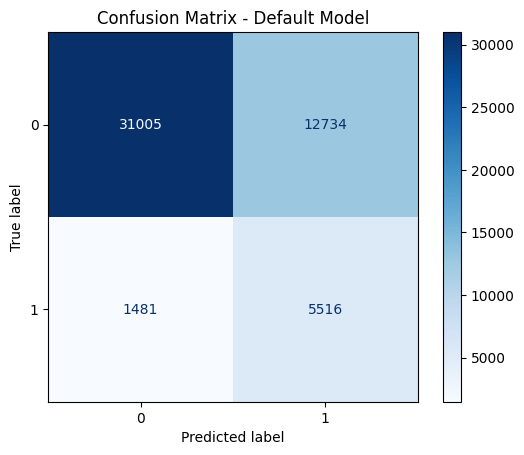

In [151]:
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X_train, y_train)

default_pipe = ImbPipeline(steps=[
    
    ("scaler", MinMaxScaler()),
    ("selectkbest", SelectKBest(score_func=chi2, k=15)),
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("xgb", XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42))
])

scoring = ['f1', 'accuracy', 'recall']
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

default_scores = cross_validate(default_pipe, X_res, y_res, cv=cv, scoring=scoring)

for metric in scoring:
    mean = np.mean(default_scores[f'test_{metric}'])
    std = np.std(default_scores[f'test_{metric}'])
    print(f"{metric}: {mean:.4f} ± {std:.4f}")

default_pipe.fit(X_res, y_res)

y_pred = default_pipe.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Default Model")
plt.show()


In [152]:
def objective(trial):
    params = {
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "n_estimators": trial.suggest_int("n_estimators", 50, 300), 
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0)
    }

    pipe = ImbPipeline(steps=[
        ("scaler", MinMaxScaler()),
        ("selectkbest", SelectKBest(score_func=chi2, k=15)),
        ("poly", PolynomialFeatures(degree=2, include_bias=False)),
        ("xgb", XGBClassifier(
            use_label_encoder=False,
            eval_metric="logloss",
            random_state=42,
            **params
        ))
    ])

    scores = cross_validate(pipe, X_res, y_res, cv=cv, scoring=scoring)
    return np.mean(scores['test_f1'])


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best hyperparameters:", study.best_params)

final_pipe = ImbPipeline(steps=[
    ("selectkbest", SelectKBest(score_func=chi2, k=15)),
    ("scaler", MinMaxScaler()),
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("xgb", XGBClassifier(
        use_label_encoder=False,
        eval_metric="logloss",
        random_state=42,
        **study.best_params
    ))
])

final_pipe.fit(X_res, y_res)

y_pred = final_pipe.predict(X_test)
y_proba = final_pipe.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred)

print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Recall: {recall:.4f}")


[I 2025-05-04 20:56:42,724] A new study created in memory with name: no-name-e0a55288-c818-45fe-993b-1126f4a8409f
[I 2025-05-04 20:57:19,583] Trial 0 finished with value: 0.754563635575823 and parameters: {'max_depth': 9, 'n_estimators': 122, 'learning_rate': 0.030233745493122053, 'subsample': 0.7904607632271217, 'colsample_bytree': 0.9624873054164856}. Best is trial 0 with value: 0.754563635575823.
[I 2025-05-04 20:57:30,520] Trial 1 finished with value: 0.7558307195234782 and parameters: {'max_depth': 5, 'n_estimators': 57, 'learning_rate': 0.03154109424367864, 'subsample': 0.5762104253589739, 'colsample_bytree': 0.9719635337450954}. Best is trial 1 with value: 0.7558307195234782.
[I 2025-05-04 20:57:54,298] Trial 2 finished with value: 0.7561275980376713 and parameters: {'max_depth': 3, 'n_estimators': 287, 'learning_rate': 0.20523316420603957, 'subsample': 0.7077496175618263, 'colsample_bytree': 0.7487734583676284}. Best is trial 2 with value: 0.7561275980376713.
[I 2025-05-04 20:5

Best hyperparameters: {'max_depth': 5, 'n_estimators': 188, 'learning_rate': 0.04108862075412971, 'subsample': 0.5266976890071263, 'colsample_bytree': 0.834098230428868}
Accuracy: 0.7216
F1 Score: 0.7632
Recall: 0.8023


# Uploading model, best parameters, metrics to Wandb

In [153]:
run = wandb.init(project="risk_credit", job_type="model-training", name="xgboost_optuna_best_model")

wandb.config.update(study.best_params)

wandb.log({
    "accuracy": accuracy_score(y_test, y_pred),
    "f1_score": f1_score(y_test, y_pred, average="weighted"),
    "recall": recall_score(y_test, y_pred)
})

import joblib

joblib.dump(final_pipe, "final_model.pkl")

artifact = wandb.Artifact("final_xgb_model", type="model")
artifact.add_file("final_model.pkl")
wandb.log_artifact(artifact)

run.finish()

accuracy,▁
f1_score,▁
recall,▁
accuracy,0.72156
f1_score,0.76316
recall,0.80234
